# Feature engineering and selection

In this notebook the follow tasks will be performed

1. Dataset loading
2. Dataset split
3. Continuous vs discrete variables
4. Discrete variables reordering
5. Continuous Target Transformation
7. Removing Correlated variables
8. Feature Scaling
8. Feature selection by Lasso
9. Saving processed dataset

## 1. Dataset loading

In [329]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [331]:
df = pd.read_csv('../data/completion_rate.csv')

In [332]:
df.head()

,form_id,views,submissions,feat_01,feat_02,feat_03,feat_04,feat_05,feat_06,feat_07,...,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47
0,1113027,33,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,1115313,147,111,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1115907,528,136,0.0,1.0,0.0,0.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0
3,1116299,55,21,0.0,2.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
4,1120373,62,54,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,11.0,7.0,21.0


Let's add the target column and remove unwanted columns from the dataset

In [333]:
df['completion_ratio'] = df['submissions']/df['views']
selected_columns = list(df.columns)
selected_columns.pop(selected_columns.index('form_id'))
selected_columns.pop(selected_columns.index('views'))
selected_columns.pop(selected_columns.index('submissions'))
df = df.loc[:,selected_columns]

In [334]:
target_name = 'completion_ratio'
features = list(df.columns)
_  = features.pop(features.index(target_name))

Let's sample the dataset for the analysis to finish on time

In [335]:
df_original = df.copy()
print("original dataset length",len(df_original))
df = df_original.sample(frac=0.1)
print("sampled dataset length",len(df))

original dataset length 1031284
sampled dataset length 103128


## 2. Dataset split

In [336]:

X_train, X_test, y_train, y_test = train_test_split(
    df,
    df['completion_ratio'],
    test_size=0.1,
    random_state=7,
)  

X_train = X_train.copy()
X_test = X_test.copy()
X_train.shape, X_test.shape

((92815, 48), (10313, 48))

## 3. Continuous vs discrete variables

Let's determine which are continuous and discrete variables in the dataset.

In [337]:
discrete_vars = []
for var in df.columns:
    #print(var,len(df[var].unique()))
    if len(df[var].unique()) == len(df):
        print("found id or continuous var",var)
    elif df[var].dtypes == 'int64' and len(df[var].unique()) < 20:
        print("found possible discrete var",var)
        discrete_vars.append(var)
    elif len(df[var].unique()) < 20:
        print("found possible discrete var with misleading type",var, len(df[var].unique()))
        discrete_vars.append(var)
        
continuous_vars = [ col for col in df.columns if col not in discrete_vars]
print("\ndiscrete vars", discrete_vars)
print("\ncontinuous vars", continuous_vars)

found possible discrete var with misleading type feat_01 2
found possible discrete var with misleading type feat_04 3
found possible discrete var with misleading type feat_05 19
found possible discrete var with misleading type feat_08 10
found possible discrete var with misleading type feat_10 6
found possible discrete var with misleading type feat_12 18
found possible discrete var with misleading type feat_13 10
found possible discrete var with misleading type feat_15 9
found possible discrete var with misleading type feat_20 2
found possible discrete var with misleading type feat_26 15
found possible discrete var with misleading type feat_31 12
found possible discrete var with misleading type feat_35 11
found possible discrete var with misleading type feat_42 17
found possible discrete var with misleading type feat_43 19
found possible discrete var with misleading type feat_44 16

discrete vars ['feat_01', 'feat_04', 'feat_05', 'feat_08', 'feat_10', 'feat_12', 'feat_13', 'feat_15', '

## 4. Discrete variables reordering

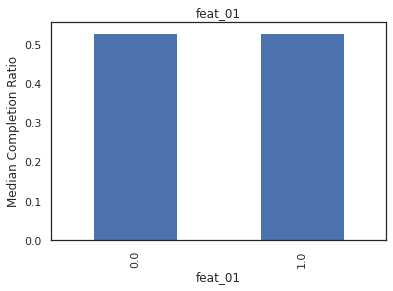

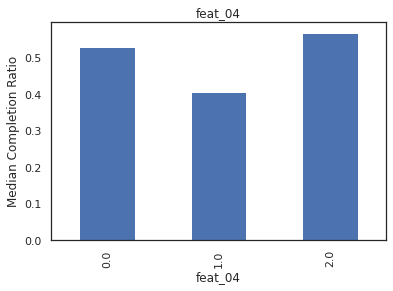

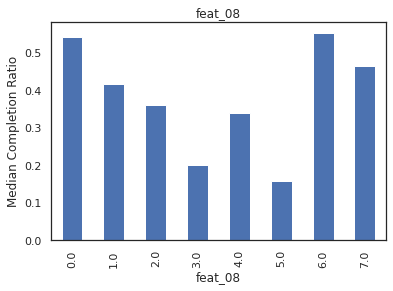

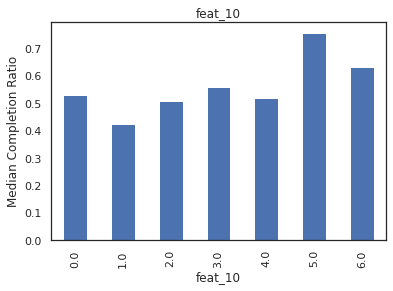

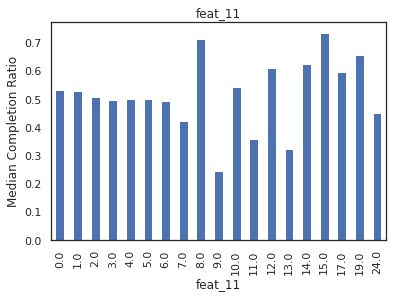

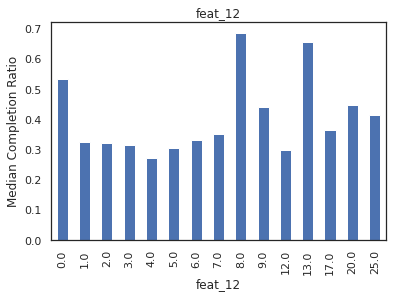

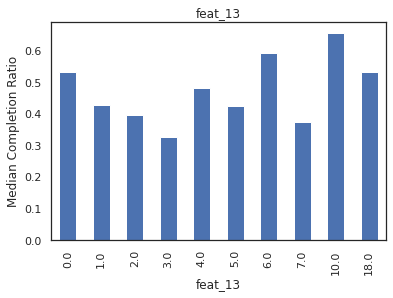

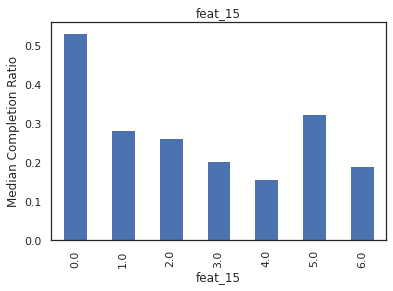

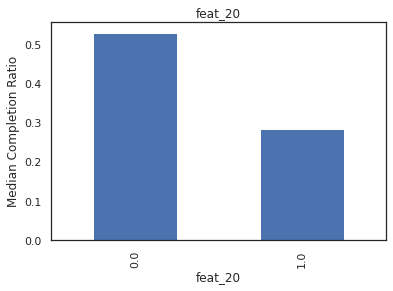

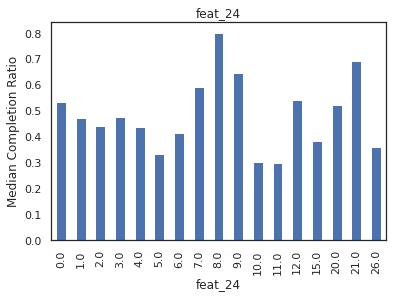

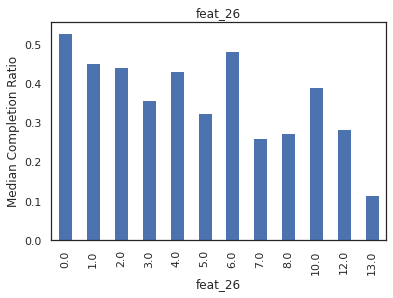

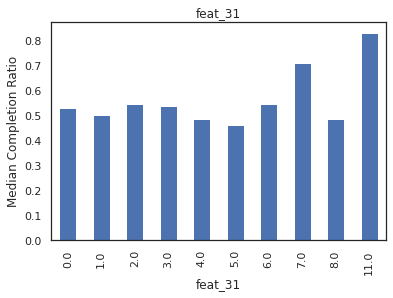

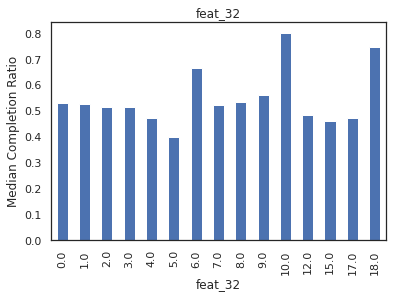

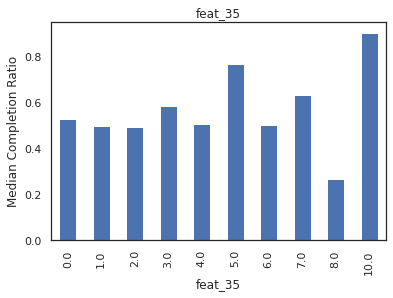

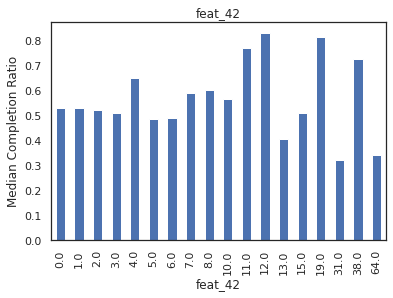

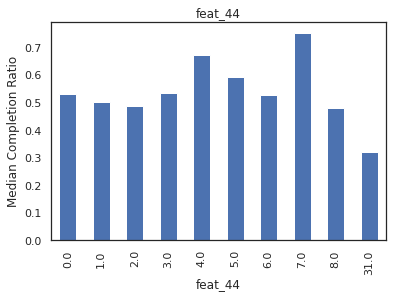

In [291]:
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)[target_name].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median Completion Ratio')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(X_train, var)

In [319]:
def assign_encoding_id(variable, x, encoding_dict):
    try:
        return encoding_dict[variable][x]
    except:
        encoding_dict[variable][x] = list(encoding_dict[variable].keys())[-1]+1
        return encoding_dict[variable][x]
    
        
encoding_dict = {}
for variable in discrete_vars:    
    # if we fit only with training data, then the splits must be 
    # stratified to each of the discrete vars that we are going
    # to reorder! But this seems not possible as stratify does it by target classe only
    # we will probably leak info into the model 
    # or do some other stuff with labels non seen like assing a new id on top of the rest
    ordered_labels = X_train.groupby([
            variable])['completion_ratio'].median().sort_values().index
    ordinal_labels = {k: i for i, k in enumerate(ordered_labels, 0)}
    # save the encoding dict
    encoding_dict[variable] = ordinal_labels
    X_train[variable] = X_train[variable].apply(lambda x: encoding_dict[variable][x])
    X_test[variable] = X_test[variable].apply(lambda x: assign_encoding_id(variable,x, encoding_dict) )
    
    

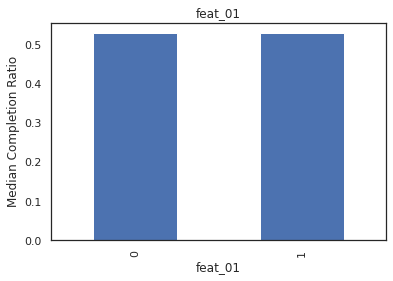

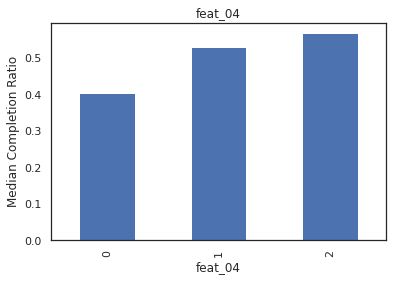

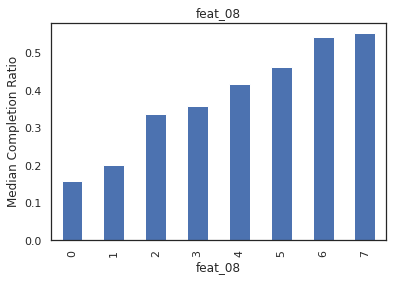

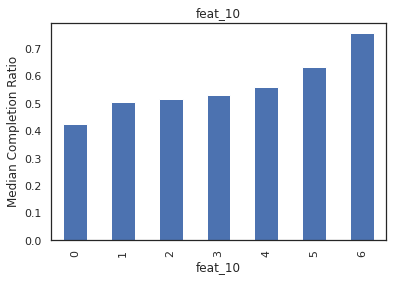

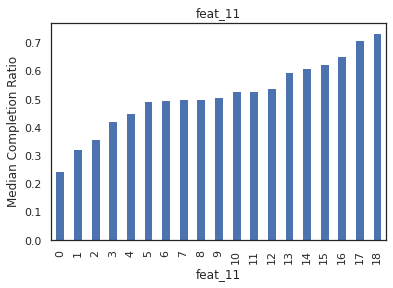

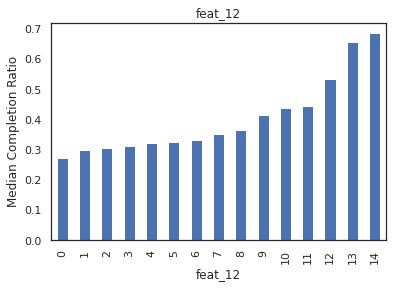

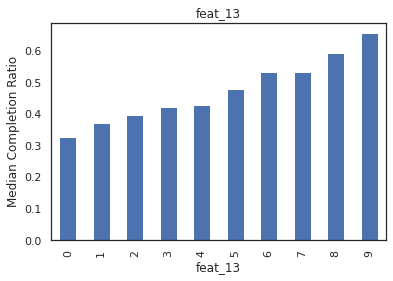

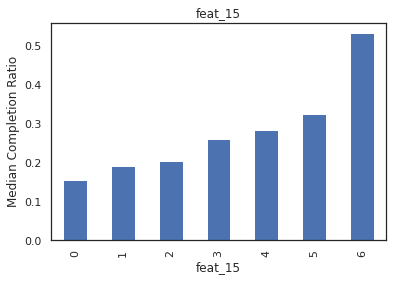

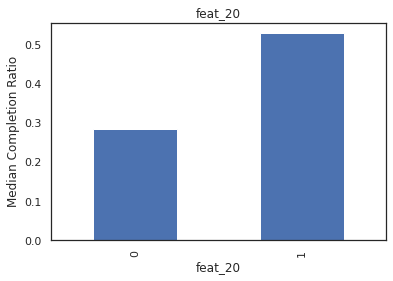

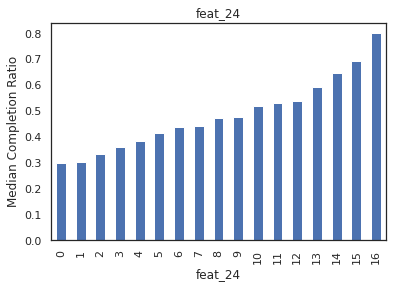

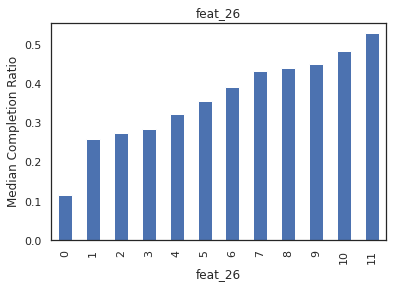

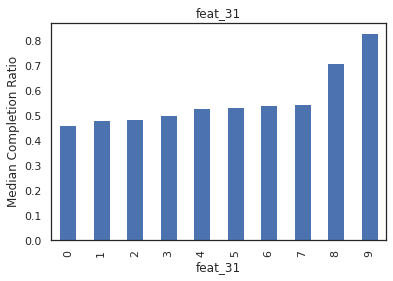

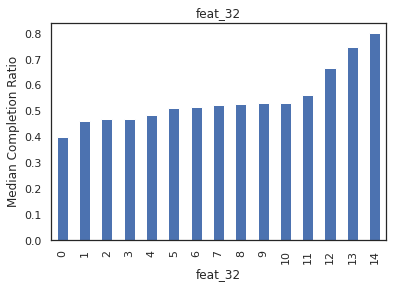

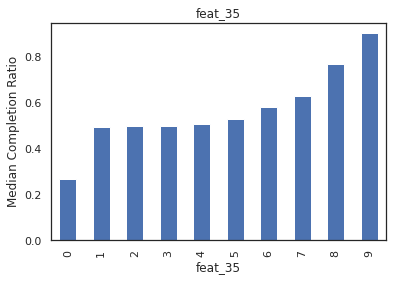

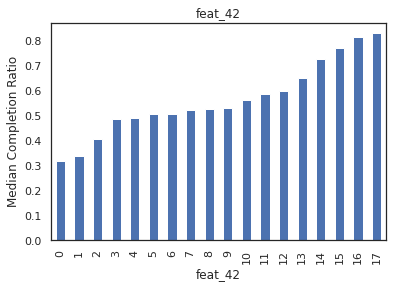

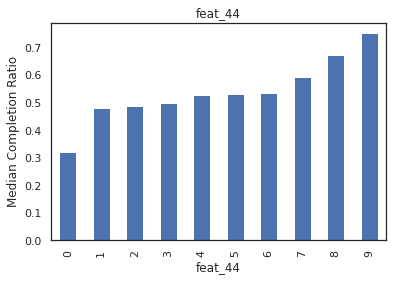

In [293]:
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)[target_name].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median Completion Ratio')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(X_train, var)

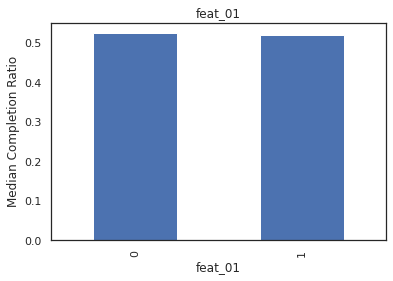

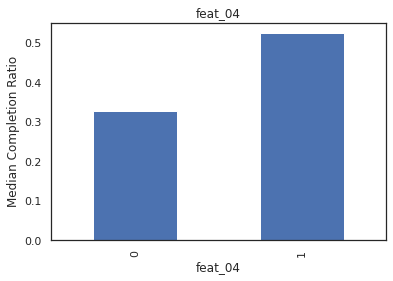

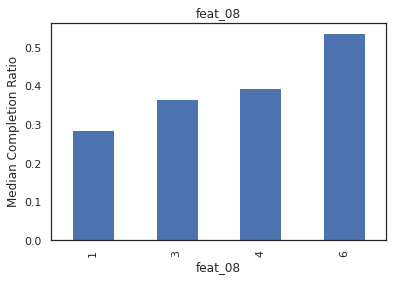

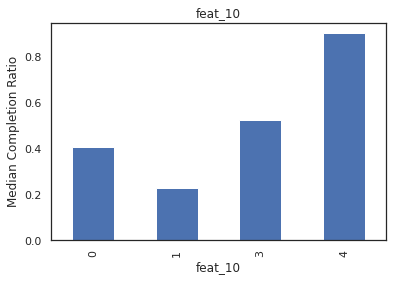

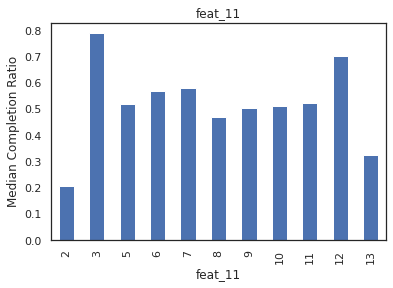

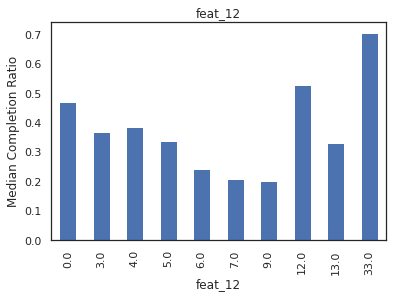

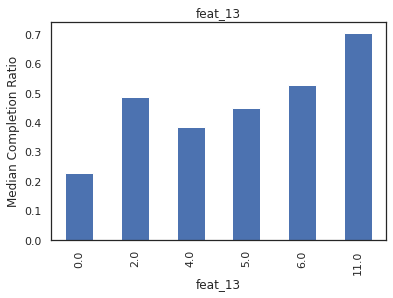

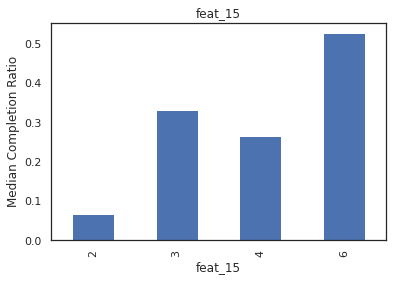

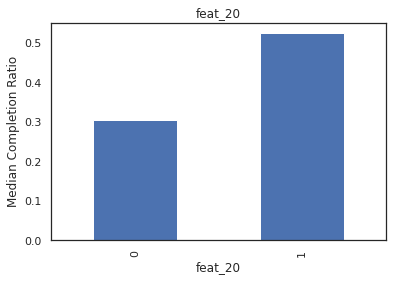

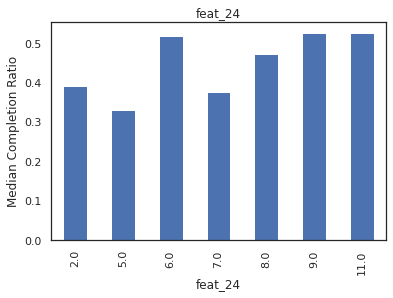

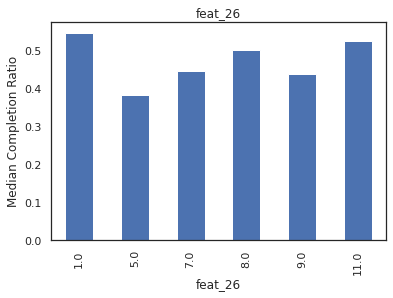

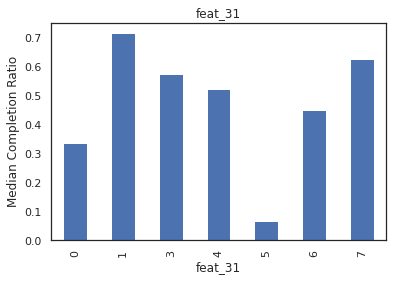

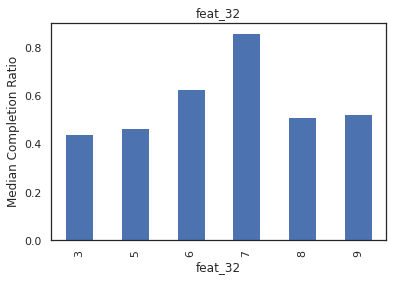

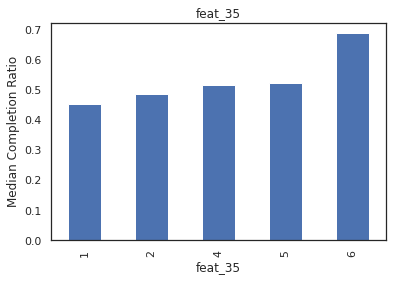

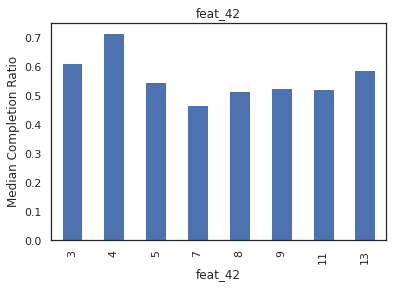

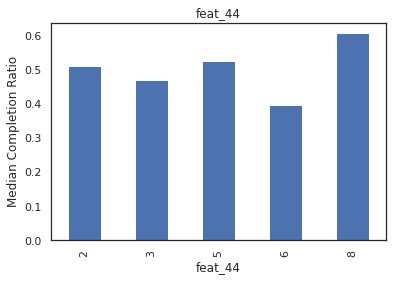

In [294]:
# this problem is kind of expected but let's try to fit the model with it and decide.
for var in discrete_vars:
    analyse_discrete(X_test, var)

## 5. Target transformation

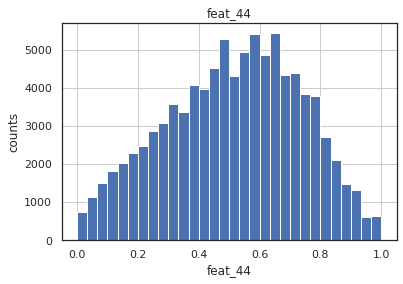

In [295]:
X_train['completion_ratio'].hist(bins=30)
plt.ylabel('counts')
plt.xlabel(var)
plt.title(var)
plt.show()

In [322]:
import pickle
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)

X_train[target_name+'_qt'] = quantile_transformer.fit_transform(X_train[target_name].to_numpy().reshape(-1,1))
pickle.dump(quantile_transformer, open('../data/qtransfromer.pkl','wb'))
X_test[target_name+'_qt'] = quantile_transformer.transform(X_test[target_name].to_numpy().reshape(-1,1))

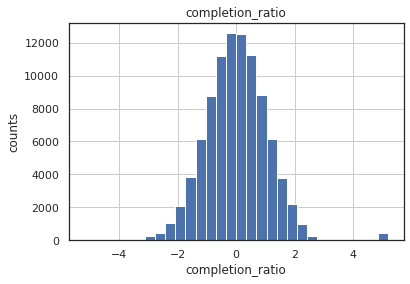

In [323]:
X_train['completion_ratio_qt'].hist(bins=30)
plt.ylabel('counts')
plt.xlabel(var)
plt.title(var)
plt.show()

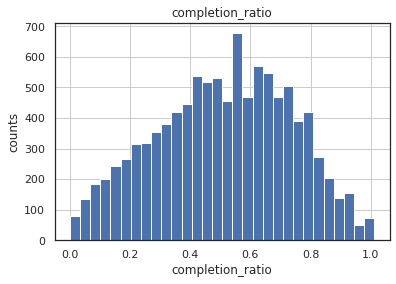

In [325]:
X_test['completion_ratio_qt'].hist(bins=30)
plt.ylabel('counts')
plt.xlabel(var)
plt.title(var)
plt.show()

## 7. Correlation

Let's detect if there are correlated features that can harm the machine learning model performance.

In [299]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")


d = X_train

# Compute the correlation matrix
corr = d.corr()

In [300]:
print("Correlation between features")
corr = d.corr()
# construct pairs (corr, (feat, feat)) and then sort them
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train, 15))


Correlation between features
Top Absolute Correlations
feat_06  feat_34    1.000000
feat_36  feat_38    0.999477
feat_19  feat_36    0.933636
         feat_38    0.933547
feat_18  feat_39    0.899283
feat_19  feat_33    0.828067
         feat_40    0.824431
feat_07  feat_47    0.815203
feat_38  feat_40    0.809410
feat_36  feat_40    0.809089
feat_05  feat_43    0.786626
feat_33  feat_36    0.774993
         feat_38    0.774949
feat_07  feat_30    0.769379
feat_45  feat_46    0.756093
dtype: float64


In [301]:
correlated_features = [
    'feat_06',
    'feat_38', # 36, 19, 40, 33
    'feat_36', # 38, 19, 40
    'feat_19', # 38, 36, 40, 33
    #'feat_40', # 19, 38, 36 -> don't removve
    'feat_43',
    'feat_07', # 47, 30
    'feat_43', # 42, 05
    'feat_46'
]
non_correlated_vars = [col for col in df.columns if col not in correlated_features]
X_train_nocorr = X_train.loc[:,non_correlated_vars].copy()
X_test_nocorr = X_test.loc[:,non_correlated_vars].copy()

X_train_nocorr.columns

Index(['feat_01', 'feat_02', 'feat_03', 'feat_04', 'feat_05', 'feat_08',
       'feat_09', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14',
       'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_20', 'feat_21',
       'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27',
       'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'feat_33',
       'feat_34', 'feat_35', 'feat_37', 'feat_39', 'feat_40', 'feat_41',
       'feat_42', 'feat_44', 'feat_45', 'feat_47', 'completion_ratio'],
      dtype='object')

## 8. Feature Scaling

In [302]:
scaler = MinMaxScaler()
train_vars = [ col for col in X_train.columns if col != 'completion_ratio']
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])

train_vars_nocorr = [ col for col in X_train_nocorr.columns if col != 'completion_ratio']
scaler.fit(X_train_nocorr[train_vars_nocorr]) 
X_train_nocorr[train_vars_nocorr] = scaler.transform(X_train_nocorr[train_vars_nocorr])
X_test_nocorr[train_vars_nocorr] = scaler.transform(X_test_nocorr[train_vars_nocorr])

# target scaling
X_train['completion_ratio_sc'] = scaler.fit_transform(X_train['completion_ratio'])
X_test['completion_ratio_sc'] = scaler.transform(X_test['completion_ratio'])
X_train['completion_ratio_qt_sc'] = scaler.fit_transform(X_train['completion_ratio_qt'])
X_test['completion_ratio_qt_sc'] = scaler.transform(X_test['completion_ratio_qt'])

X_train['completion_ratio_sc'] = scaler.fit_transform(X_train['completion_ratio'])
X_test['completion_ratio_sc'] = scaler.transform(X_test['completion_ratio'])
X_train['completion_ratio_qt_sc'] = scaler.fit_transform(X_train['completion_ratio_qt'])
X_test['completion_ratio_qt_sc'] = scaler.transform(X_test['completion_ratio_qt'])

In [303]:
X_train.head()

,feat_01,feat_02,feat_03,feat_04,feat_05,feat_06,feat_07,feat_08,feat_09,feat_10,...,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,completion_ratio
656138,0.0,0.054054,0.000000,0.5,0.0,0.0,0.000000,0.857143,0.021277,0.5,...,0.000000,0.035294,0.000000,0.529412,0.0,0.555556,0.000000,0.000000,0.000000,0.166367
320962,0.0,0.054054,0.000000,0.5,0.0,0.0,0.000000,0.857143,0.000000,0.5,...,0.000000,0.000000,0.021277,0.529412,0.0,0.555556,0.000000,0.000000,0.000000,-0.741388
991942,0.0,0.108108,0.000000,0.5,0.0,0.0,0.000000,0.857143,0.000000,0.5,...,0.000000,0.000000,0.000000,0.529412,0.0,0.555556,0.000000,0.000000,0.000000,0.524976
610800,0.0,0.000000,0.000000,0.5,0.0,0.0,0.029412,0.857143,0.000000,0.5,...,0.032258,0.000000,0.000000,0.529412,0.0,0.555556,0.008475,0.003431,0.011442,0.562592
590611,0.0,0.000000,0.020408,0.5,0.0,0.0,0.147059,0.857143,0.042553,0.5,...,0.000000,0.000000,0.000000,0.529412,0.0,0.555556,0.045763,0.029160,0.058352,-0.953744


In [304]:
X_test.head()

,feat_01,feat_02,feat_03,feat_04,feat_05,feat_06,feat_07,feat_08,feat_09,feat_10,...,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,completion_ratio
896572,1.0,0.000000,0.0,0.5,0.000000,0.0,0.000000,0.857143,0.000000,0.5,...,0.0,0.0,0.000000,0.470588,0.015625,0.555556,0.0,0.0,0.000000,0.802240
905655,0.0,0.027027,0.0,0.5,0.000000,0.0,0.000000,0.857143,0.000000,0.5,...,0.0,0.0,0.021277,0.529412,0.000000,0.555556,0.0,0.0,0.000000,-1.016058
559768,0.0,0.000000,0.0,0.5,0.000000,0.0,0.000000,0.857143,0.042553,0.5,...,0.0,0.0,0.000000,0.529412,0.000000,0.555556,0.0,0.0,0.000000,-1.912168
121092,0.0,0.000000,0.0,0.5,0.000000,0.0,0.029412,0.857143,0.021277,0.5,...,0.0,0.0,0.000000,0.529412,0.000000,0.555556,0.0,0.0,0.017162,1.368450
51839,0.0,0.000000,0.0,0.5,0.015873,0.0,0.014706,0.857143,0.000000,0.5,...,0.0,0.0,0.000000,0.529412,0.015625,0.555556,0.0,0.0,0.002288,0.838423


In [305]:
X_train_nocorr.head()

,feat_01,feat_02,feat_03,feat_04,feat_05,feat_08,feat_09,feat_10,feat_11,feat_12,...,feat_35,feat_37,feat_39,feat_40,feat_41,feat_42,feat_44,feat_45,feat_47,completion_ratio
656138,0.0,0.054054,0.000000,0.5,0.0,0.857143,0.021277,0.5,0.611111,0.857143,...,0.555556,0.040541,0.000000,0.035294,0.000000,0.529412,0.555556,0.000000,0.000000,0.166367
320962,0.0,0.054054,0.000000,0.5,0.0,0.857143,0.000000,0.5,0.555556,0.857143,...,0.555556,0.000000,0.000000,0.000000,0.021277,0.529412,0.555556,0.000000,0.000000,-0.741388
991942,0.0,0.108108,0.000000,0.5,0.0,0.857143,0.000000,0.5,0.611111,0.857143,...,0.555556,0.000000,0.000000,0.000000,0.000000,0.529412,0.555556,0.000000,0.000000,0.524976
610800,0.0,0.000000,0.000000,0.5,0.0,0.857143,0.000000,0.5,0.611111,0.857143,...,0.555556,0.000000,0.032258,0.000000,0.000000,0.529412,0.555556,0.008475,0.011442,0.562592
590611,0.0,0.000000,0.020408,0.5,0.0,0.857143,0.042553,0.5,0.444444,0.857143,...,0.555556,0.000000,0.000000,0.000000,0.000000,0.529412,0.555556,0.045763,0.058352,-0.953744


In [306]:
X_test_nocorr.head()

,feat_01,feat_02,feat_03,feat_04,feat_05,feat_08,feat_09,feat_10,feat_11,feat_12,...,feat_35,feat_37,feat_39,feat_40,feat_41,feat_42,feat_44,feat_45,feat_47,completion_ratio
896572,1.0,0.000000,0.0,0.5,0.000000,0.857143,0.000000,0.5,0.611111,0.857143,...,0.555556,0.0,0.0,0.0,0.000000,0.470588,0.555556,0.0,0.000000,0.802240
905655,0.0,0.027027,0.0,0.5,0.000000,0.857143,0.000000,0.5,0.611111,0.857143,...,0.555556,0.0,0.0,0.0,0.021277,0.529412,0.555556,0.0,0.000000,-1.016058
559768,0.0,0.000000,0.0,0.5,0.000000,0.857143,0.042553,0.5,0.611111,0.857143,...,0.555556,0.0,0.0,0.0,0.000000,0.529412,0.555556,0.0,0.000000,-1.912168
121092,0.0,0.000000,0.0,0.5,0.000000,0.857143,0.021277,0.5,0.611111,0.857143,...,0.555556,0.0,0.0,0.0,0.000000,0.529412,0.555556,0.0,0.017162,1.368450
51839,0.0,0.000000,0.0,0.5,0.015873,0.857143,0.000000,0.5,0.611111,0.857143,...,0.555556,0.0,0.0,0.0,0.000000,0.529412,0.555556,0.0,0.002288,0.838423


## 9. Feature Selection

In [307]:
sel_ = SelectFromModel(Lasso(alpha=0.0001, random_state=7))

# train Lasso model and select features
X_train_ls = X_train.loc[:,train_vars].copy()
sel_.fit(X_train_ls, y_train)
selected_feats = X_train_ls.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train_ls.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))
print(selected_feats)
pd.Series(selected_feats).to_csv('../data/selected_features.csv', index=False)


total features: 47
selected features: 18
features with coefficients shrank to zero: 29
Index(['feat_01', 'feat_02', 'feat_06', 'feat_07', 'feat_08', 'feat_09',
       'feat_10', 'feat_12', 'feat_13', 'feat_15', 'feat_17', 'feat_20',
       'feat_24', 'feat_26', 'feat_27', 'feat_33', 'feat_35', 'feat_44'],
      dtype='object')


In [308]:
sel_ = SelectFromModel(Lasso(alpha=0.0001, random_state=7))

# train Lasso model and select features
X_train_ls = X_train_nocorr.loc[:,train_vars_nocorr].copy()
print(X_train_ls.columns)
sel_.fit(X_train_ls, y_train)
selected_feats = X_train_ls.columns[(sel_.get_support())]
# let's print some stats
print('total features: {}'.format((X_train_ls.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))
print(selected_feats)
pd.Series(selected_feats).to_csv('../data/selected_features_nocorr.csv', index=False)


Index(['feat_01', 'feat_02', 'feat_03', 'feat_04', 'feat_05', 'feat_08',
       'feat_09', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14',
       'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_20', 'feat_21',
       'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27',
       'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'feat_33',
       'feat_34', 'feat_35', 'feat_37', 'feat_39', 'feat_40', 'feat_41',
       'feat_42', 'feat_44', 'feat_45', 'feat_47'],
      dtype='object')
total features: 40
selected features: 18
features with coefficients shrank to zero: 22
Index(['feat_01', 'feat_02', 'feat_08', 'feat_09', 'feat_10', 'feat_12',
       'feat_13', 'feat_15', 'feat_17', 'feat_20', 'feat_24', 'feat_26',
       'feat_27', 'feat_30', 'feat_33', 'feat_34', 'feat_35', 'feat_44'],
      dtype='object')


## 10. Saving processed data

In [328]:

X_train.to_csv('../data/xtrain.csv', index=False)
X_test.to_csv('../data/xtest.csv', index=False)

X_train_nocorr.to_csv('../data/xtrain_nocorr.csv', index=False)
X_test_nocorr.to_csv('../data/xtest_nocorr.csv', index=False)

In [327]:
print(len(X_test))
print(len(X_train))
print(len(X_test_nocorr))
print(len(X_train_nocorr))

10313
92815
10313
92815


The saved preprocessed data can be loaded from the files:
* X_train.csv
* X_test.csv
* X_train_nocorr.csv for a removal of correlated vars
* X_test_nocorr.csv

The selected features from the Lasso are saved in:
* selected_features.csv and selected_features_nocorr.csv respectively